In [277]:
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import os
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from sklearn.pipeline import Pipeline
import joblib
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score,roc_auc_score,roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score, learning_curve

#### Loading the dataset

In [278]:
directory_path = 'Dataset/new_feature_csv'
regular_data = []
attack_data = []
for subfolder in os.listdir(directory_path):
    subfolder_path = os.path.join(directory_path, subfolder)
    if os.path.isdir(subfolder_path):
        for filename in os.listdir(subfolder_path):
            if filename.endswith(".csv"):
                file_path = os.path.join(subfolder_path, filename)
                df = pd.read_csv(file_path)
                if subfolder == 'Regular':
                    df['Label'] = -1
                    regular_data.append(df)
                else:
                    df['Label'] = 1
                    attack_data.append(df)
all_regular_raw_data = pd.concat(regular_data, ignore_index=True)
all_attack_raw_data = pd.concat(attack_data, ignore_index=True)

#### Data Preprocessing

In [ ]:
all_regular_data_sh=shuffle(all_regular_raw_data, random_state=42)
all_attack_data_sh=shuffle(all_attack_raw_data, random_state=42)

In [281]:
X_train_regular, X_remaining_regular = train_test_split(all_regular_data_sh, test_size=0.40, random_state=42)
X_validation_regular, X_test_regular = train_test_split(X_remaining_regular, test_size=0.50, random_state=42)
X_validation_attack, X_remaining_attack = train_test_split(all_attack_data_sh, test_size=0.80, random_state=42)
X_validation_combined = pd.concat([X_validation_regular, X_validation_attack], ignore_index=True)
X_validation_combined_sh = shuffle(X_validation_combined, random_state=42)
X_test_combined = pd.concat([X_test_regular, X_remaining_attack], ignore_index=True)
X_test_combined_sh = shuffle(X_test_combined, random_state=42)

#### Imputation and Normalization

In [282]:
y_tr=X_train_regular["Label"]
y_va=X_validation_combined_sh["Label"]
y_te=X_test_combined_sh["Label"]
X_tr = X_train_regular.drop('Label', axis=1)
X_va = X_validation_combined_sh.drop('Label', axis=1)
X_te = X_test_combined_sh.drop('Label', axis=1)

In [283]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='median'))
])

In [284]:
X_train = pipeline.fit_transform(X_tr)
X_validation = pipeline.transform(X_va)
X_test = pipeline.transform(X_te)

#### Tuning Process

In [285]:
pca_components = [0.80, 0.90, 0.95]
results = {}

for component in pca_components:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=component)),
        ('iso_forest', IsolationForest())
    ])

    scores = cross_val_score(pipeline, X_train, -y_tr, cv=5, scoring='f1')
    mean_score = np.mean(scores)
    
    results[component] = mean_score

best_component = max(results, key=results.get)
best_score = results[best_component]

print(f"Best PCA component ratio: {best_component}")
print(f"Best F1 Score: {best_score}")

Best PCA component ratio: 0.95
Best F1 Score: 0.9767172295895421


In [286]:
pca_tr=PCA(n_components=best_component)
X_train_pca=pca_tr.fit_transform(X_train)
X_validation_pca = pca_tr.transform(X_validation)
X_test_pca = pca_tr.transform(X_test)

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_samples': ['auto', 0.5, 0.75, 1.0],
    'contamination': [0.01, 0.05, 0.1, 0.2],
    'max_features': [1.0, 0.5, 0.75]
}
best_params = None
best_f1 = -1
best_model = None
for n_estimators in param_grid['n_estimators']:
    for max_samples in param_grid['max_samples']:
        for contamination in param_grid['contamination']:
            for max_features in param_grid['max_features']:
                iso_forest = IsolationForest(
                    n_estimators=n_estimators,
                    max_samples=max_samples,
                    contamination=contamination,
                    max_features=max_features,
                    random_state=42)
                iso_forest.fit(X_train_pca)
                val_predictions = -iso_forest.predict(X_validation_pca)
                f1 = f1_score(y_va, val_predictions)
                if f1 > best_f1:
                    best_f1 = f1
                    best_params = {
                        'n_estimators': n_estimators,
                        'max_samples': max_samples,
                        'contamination': contamination,
                        'max_features': max_features}
                    best_model = iso_forest
print(f'Best Parameters: {best_params}')
print(f'Best F1 Score: {best_f1}')
best_filename = f"best_isolation_forest_{best_params['n_estimators']}_{best_params['max_samples']}_{best_params['contamination']}_{best_params['max_features']}.pkl"
joblib.dump(best_model, best_filename)
print(f'Best model saved as {best_filename}')


Best Parameters: {'n_estimators': 50, 'max_samples': 0.75, 'contamination': 0.01, 'max_features': 0.5}
Best F1 Score: 0.9962755662186378
Best model saved as best_isolation_forest_50_0.75_0.01_0.5.pkl


#### Examine The Result

##### Loading Pre-trained Model

In [288]:
best_model_filename = best_filename
best_model = joblib.load(best_model_filename)

##### Cross-Validation

In [289]:
pipeline_isfo= Pipeline([
    ('pca', PCA(n_components=best_component)),
    ('iso', best_model)
])
cv_scores = cross_val_score(pipeline_isfo, X_train_pca, -y_tr, cv=5, scoring='f1', n_jobs=-1)
print(f'Cross-Validation F1 Scores: {cv_scores}')
print(f'Mean Cross-Validation F1 Score: {cv_scores.mean()}')

Cross-Validation F1 Scores: [0.99496824 0.99497481 0.99494195 0.99504049 0.99484003]
Mean Cross-Validation F1 Score: 0.9949531037168244


##### Learning Curve Plot

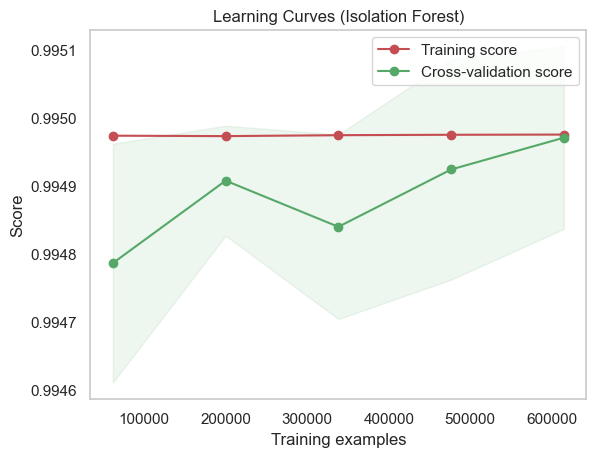

In [290]:
train_sizes, train_scores, val_scores = learning_curve(best_model, X_train_pca, -y_tr, cv=5, scoring='f1', n_jobs=-1)

train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
val_scores_mean = val_scores.mean(axis=1)
val_scores_std = val_scores.std(axis=1)

plt.figure()
plt.title("Learning Curves (Isolation Forest)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")

plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()


#### Performance Evaluation Metrics

Accuracy: 0.9957739092357905
Precision: 0.9925787723083893
Recall: 1.0
F1 Score: 0.9962755662186378
ROC AUC: 0.9951398133219863
Confusion Matrix:
[[333034      0]
 [  2490 253673]]


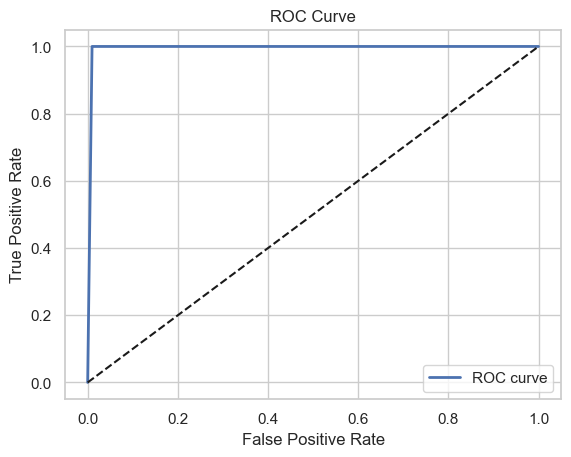

In [291]:
y_va_pred = -best_model.predict(X_validation_pca)

accuracy = accuracy_score(y_va, y_va_pred)
precision = precision_score(y_va, y_va_pred)
recall = recall_score(y_va, y_va_pred)
f1 = f1_score(y_va, y_va_pred)
roc_auc = roc_auc_score(y_va, y_va_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC: {roc_auc}')

conf_matrix = confusion_matrix(y_va, y_va_pred,labels=[1,-1])
print('Confusion Matrix:')
print(conf_matrix)


fpr, tpr, thresholds = roc_curve(y_va, y_va_pred)
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()